In [1]:
# Clean up old CSV files and re-run
#!rm actions_*.csv outcomes_*.csv;

In [2]:
#from battle import main

#main(100, 2)

In [3]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotnine as pn
rnd = np.random.default_rng()

Experiment_Name = 'vsMedusaNoStrat'

In [4]:
def load(p):
    df = pd.read_csv(p)
    df['csv'] = str(p)
    return df

df = pd.concat([load(x) for x in Path().glob(f"output/{Experiment_Name}/outcomes_*.csv") if x.stat().st_size > 1000], ignore_index=True)
df.team = np.array(['PCs', 'monsters'])[df.team]
df.head()

,epoch,encounter,num_rounds,actor,team,team_win,max_hp,final_hp,csv
0,0,0,14,Cleric 1,PCs,False,16,-14,output\vsMedusaNoStrat\outcomes_11700.csv
1,0,0,14,Fighter 1,PCs,False,20,-14,output\vsMedusaNoStrat\outcomes_11700.csv
2,0,0,14,Medusa 1,monsters,True,76,60,output\vsMedusaNoStrat\outcomes_11700.csv
3,0,0,14,Archer 1,PCs,False,18,-12,output\vsMedusaNoStrat\outcomes_11700.csv
4,0,0,14,Defender 1,PCs,False,24,-18,output\vsMedusaNoStrat\outcomes_11700.csv


How injured does each actor end up?

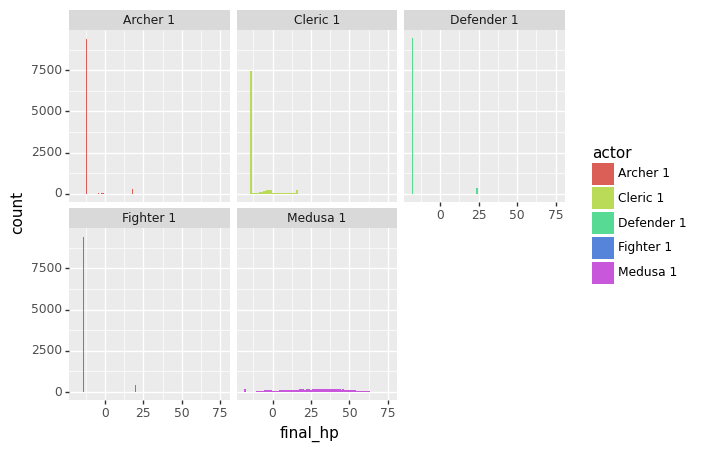

<ggplot: (107505811408)>

In [5]:
x = df[df.epoch > df.epoch.max()-10].copy() # last 10 epochs
#x = x.groupby(['epoch', 'encounter', 'csv', 'team']).sum()
#x['frac_hp'] = x.final_hp / x.max_hp
x = x.reset_index()
#pn.qplot('max_hp', data=x, geom='histogram', fill='actor', binwidth=1) + pn.facet_wrap('actor')
pn.qplot('final_hp', data=x, geom='histogram', fill='actor', binwidth=1) + pn.facet_wrap('actor')

How many wins do we obtain during the last 10 epochs?

In [6]:
wins = df.loc[(df['epoch']>=90) & (df['team']=='PCs')]
print(wins)

        epoch  encounter  num_rounds       actor team  team_win  max_hp  \
227407     90          0           7    Archer 1  PCs     False      18   
227409     90          0           7    Cleric 1  PCs     False      16   
227410     90          0           7   Fighter 1  PCs     False      20   
227411     90          0           7  Defender 1  PCs     False      24   
227413     90          1           4    Archer 1  PCs     False      18   
...       ...        ...         ...         ...  ...       ...     ...   
502059     99        462           5    Cleric 1  PCs     False      16   
502061     99        462           5  Defender 1  PCs     False      24   
502063     99        463           6   Fighter 1  PCs     False      20   
502064     99        463           6    Archer 1  PCs     False      18   
502065     99        463           6  Defender 1  PCs     False      24   

        final_hp                                        csv  
227407       -12  output\vsMedusaNoSt

In [7]:
wins_avg = wins['team_win'].sum()/len(wins)
print(wins_avg)

0.12404661816900345


In [8]:
def load(p):
    df = pd.read_csv(p)
    df['csv'] = str(p)
    return df

df = pd.concat([load(x) for x in Path().glob(f"output/{Experiment_Name}/actions_*.csv") if x.stat().st_size > 1000], ignore_index=True)
df.head(20)

,epoch,encounter,round,actor,action,target,t_fullDefense,t_weakest,raw_hp,obs_hp,csv
0,0,0,0,Cleric 1,Cure Light Wounds,Fighter 1,False,False,10,0.0,output\vsMedusaNoStrat\actions_11700.csv
1,0,0,0,Fighter 1,Longbow,Medusa 1,False,True,-16,-16.0,output\vsMedusaNoStrat\actions_11700.csv
2,0,0,0,Medusa 1,Petrification,Defender 1,False,False,-38,-38.0,output\vsMedusaNoStrat\actions_11700.csv
3,0,0,0,Archer 1,Rapid Shot Longbow,Medusa 1,False,True,0,0.0,output\vsMedusaNoStrat\actions_11700.csv
4,0,0,0,Defender 1,Full Defense,Defender 1,False,False,0,0.0,output\vsMedusaNoStrat\actions_11700.csv
5,0,0,1,Cleric 1,Cure Light Wounds,Archer 1,False,False,4,0.0,output\vsMedusaNoStrat\actions_11700.csv
6,0,0,1,Medusa 1,Petrification,Archer 1,False,True,-30,-30.0,output\vsMedusaNoStrat\actions_11700.csv
7,0,0,1,Defender 1,Full Defense,Defender 1,False,False,0,0.0,output\vsMedusaNoStrat\actions_11700.csv
8,0,0,2,Cleric 1,Cure Light Wounds,Defender 1,True,False,3,0.0,output\vsMedusaNoStrat\actions_11700.csv
9,0,0,2,Medusa 1,Petrification,Cleric 1,False,True,-30,-30.0,output\vsMedusaNoStrat\actions_11700.csv


How long do battles typically last, as a function of epoch?

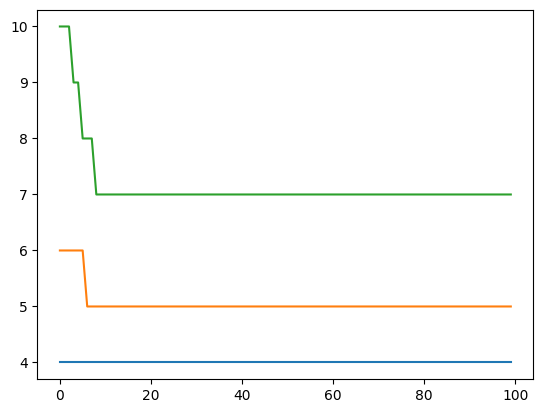

In [9]:
x = df.groupby(['epoch', 'encounter', 'csv'])['round'].max().groupby('epoch')
y = x.quantile(0.1)+1; plt.plot(y.index, y)
y = x.quantile(0.5)+1; plt.plot(y.index, y)
y = x.quantile(0.9)+1; plt.plot(y.index, y)
plt.show()

How often do we choose each possible action, as a function of time?

In [21]:
actionchoices = pn.qplot('epoch', data=df, fill='action', geom='histogram', binwidth=1) + pn.facet_wrap('actor')
actionchoices.save('figures/fig3.pdf')

C:\Users\wlecl\PycharmProjects\PathfinderRL\pathfindervenv\lib\site-packages\plotnine\ggplot.py:718: PlotnineWarning: Saving 6.4 x 4.8 in image.
C:\Users\wlecl\PycharmProjects\PathfinderRL\pathfindervenv\lib\site-packages\plotnine\ggplot.py:719: PlotnineWarning: Filename: figures/fig3.png


Close-up from final epoch:

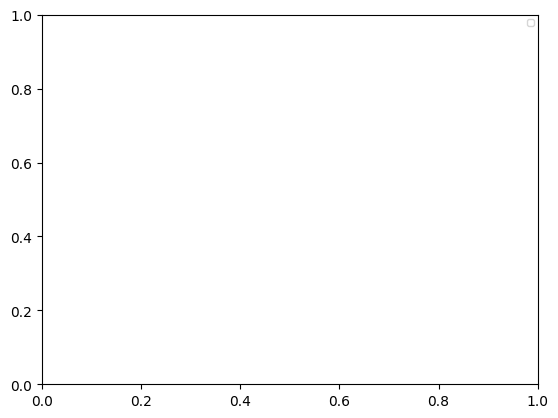

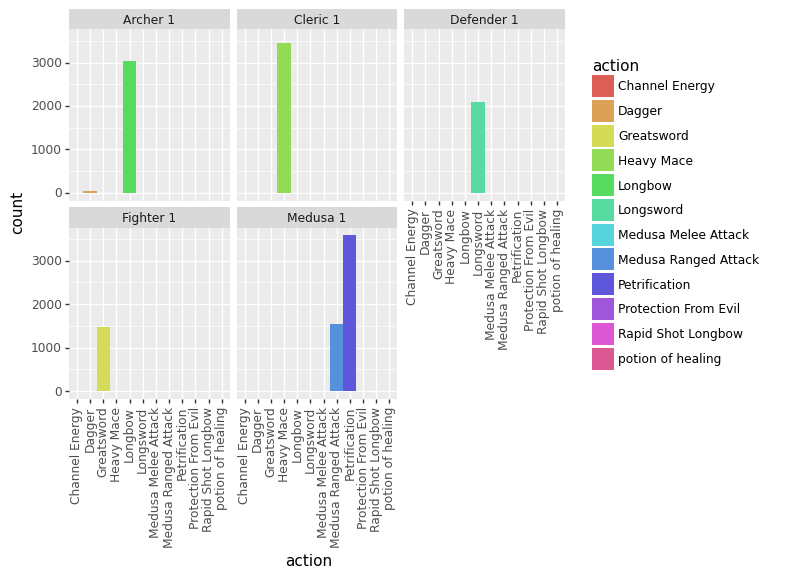

<ggplot: (107378201619)>

In [11]:
x = df[df.epoch == df.epoch.max()]
pn.qplot('action', data=x, fill='action', geom='histogram', binwidth=1, ) + pn.facet_wrap('actor') + pn.theme(axis_text_x=pn.element_text(rotation=90))

Do we use our healing potions more effectively as time goes on?

In [12]:
# Mean effect?
x = df.query('raw_hp > 0').groupby('epoch')['obs_hp'].mean()
plt.plot(x.index, x)
# How often do we use it when we're uninjured?  Not often, it's forbidden.
# x = df.query('raw_hp > 0 and obs_hp == 0').groupby('epoch').count()
# plt.plot(x.index, x.obs_hp)

Which enemy does each character attack?

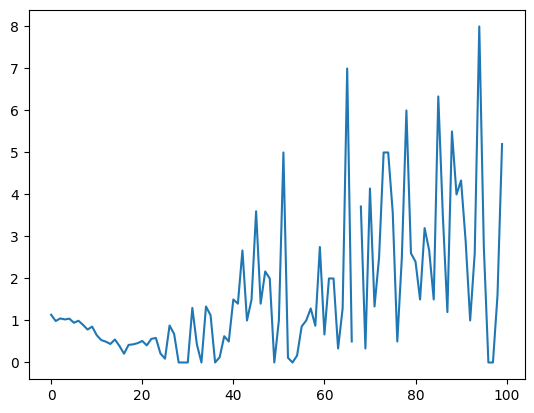

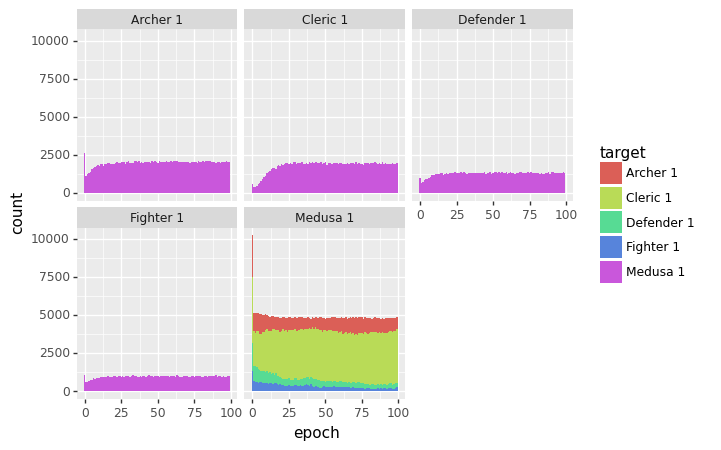

<ggplot: (107378541162)>

In [13]:
x = df.query('raw_hp < 0')
pn.qplot('epoch', data=x, fill='target', geom='histogram', binwidth=1) + pn.facet_wrap('actor')

How often do we target the weakest enemy?

C:\Users\wlecl\PycharmProjects\PathfinderRL\pathfindervenv\lib\site-packages\plotnine\positions\position_stack.py:100: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
C:\Users\wlecl\PycharmProjects\PathfinderRL\pathfindervenv\lib\site-packages\plotnine\positions\position_stack.py:100: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
C:\Users\wlecl\PycharmProjects\PathfinderRL\pathfindervenv\lib\site-packages\plotnine\positions\position_stack.py:100: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
C:\Users\wlecl\PycharmProjects\PathfinderRL\pathfindervenv\lib\site-packages\plotnine\positions\position_stack.py:100: Futur

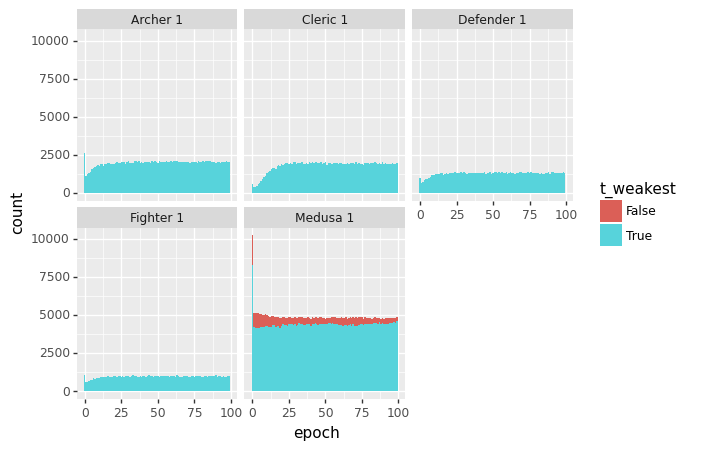

<ggplot: (107378446038)>

In [14]:
x = df.query('raw_hp < 0')
pn.qplot('epoch', data=x, fill='t_weakest', geom='histogram', binwidth=1) + pn.facet_wrap('actor')

How often do we switch targets within an encounter?

In [15]:
x = df.query('actor == "Hero" and action == "long sword"').copy()
#x['round2'] = x.groupby(['epoch', 'encounter', 'csv'])['round'].rank().astype('int')
# Convert target to numerical values
x['tgt'] = pd.Categorical(x.target).codes
# Detect changes in target
x['change_tgt'] = (x.groupby(['epoch', 'encounter', 'csv'])['tgt'].diff() != 0)
x.head()
#dir(x.tgt.cat)

,epoch,encounter,round,actor,action,target,t_fullDefense,t_weakest,raw_hp,obs_hp,csv,tgt,change_tgt


In [16]:
# Minimum is 2 (for a win):  initial attack, and switch to second target
y = x.groupby('epoch')['change_tgt'].sum() / 1000
plt.plot(y.index, y)

Which enemy do we attack first?

In [17]:
y = x.query('round == 0').groupby('epoch')['tgt'].mean()
plt.plot(y.index, y)

Look at a random encounter from the final epoch of training...

In [18]:
x = df[(df.epoch == df.epoch.max()) & (df.csv == rnd.choice(df.csv))]
x = x[x.encounter == rnd.choice(x.encounter)]
x

,epoch,encounter,round,actor,action,target,t_fullDefense,t_weakest,raw_hp,obs_hp,csv
772169,99,169,0,Fighter 1,Greatsword,Medusa 1,False,True,-12,-12.0,output\vsMedusaNoStrat\actions_22936.csv
772170,99,169,0,Defender 1,Longsword,Medusa 1,False,True,-4,-4.0,output\vsMedusaNoStrat\actions_22936.csv
772171,99,169,0,Archer 1,Longbow,Medusa 1,False,True,-4,-4.0,output\vsMedusaNoStrat\actions_22936.csv
772172,99,169,0,Medusa 1,Medusa Ranged Attack,Cleric 1,False,True,-1,-1.0,output\vsMedusaNoStrat\actions_22936.csv
772173,99,169,0,Cleric 1,Heavy Mace,Medusa 1,False,True,-5,-5.0,output\vsMedusaNoStrat\actions_22936.csv
772174,99,169,1,Fighter 1,Greatsword,Medusa 1,False,True,0,0.0,output\vsMedusaNoStrat\actions_22936.csv
772175,99,169,1,Defender 1,Longsword,Medusa 1,False,True,0,0.0,output\vsMedusaNoStrat\actions_22936.csv
772176,99,169,1,Archer 1,Longbow,Medusa 1,False,True,0,0.0,output\vsMedusaNoStrat\actions_22936.csv
772177,99,169,1,Medusa 1,Petrification,Cleric 1,False,True,-29,-29.0,output\vsMedusaNoStrat\actions_22936.csv
772178,99,169,1,Cleric 1,Heavy Mace,Medusa 1,False,True,0,0.0,output\vsMedusaNoStrat\actions_22936.csv


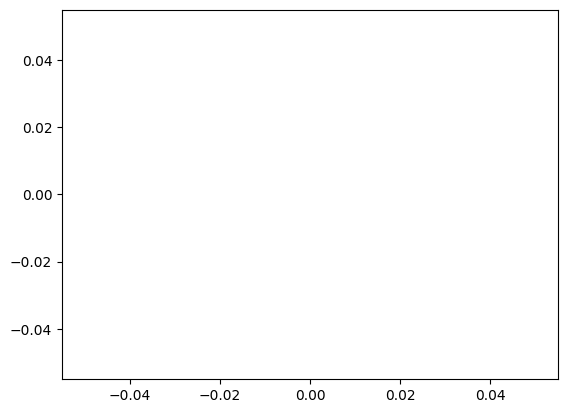

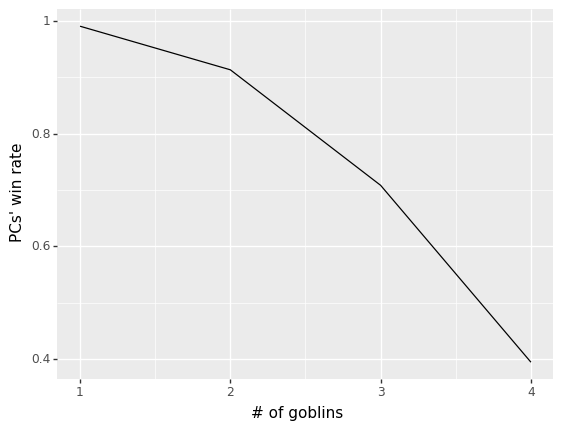

<ggplot: (107375188149)>

In [19]:
# Wins and losses at 2nd level:  2 fighters and 2 wizards vs. X goblins
goblin_win_rate = {
    1: 0.9905121403795144,
    2: 0.9132,
    3: 0.7082369506185257,
    4: 0.3944723618090452
}

zombie_win_rate = {
    1: 0.9749396135265701,
    2: 0.7595458199356914,
    3: 0,
    4: 0
}
#plt.plot(pc_win_rate.keys(), pc_win_rate.values())
pn.qplot(list(goblin_win_rate.keys()), list(goblin_win_rate.values()), geom='line', xlab='# of goblins', ylab="PCs' win rate")